In [1]:
import pathlib
import numpy as np
import xarray as xr
import datetime
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

#### Plotting functions

In [2]:
def plot_setup(fig, projection, lon_range, lat_range, xticks=None, yticks=None):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## increase resolution for projection
    ## (otherwise lines plotted on surface won't follow curved trajectories)
    projection.threshold /= 1000

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines(linewidths=0.5)

    ## add tick labels
    if xticks is not None:

        ## add lon/lat labels
        gl = ax.gridlines(
            draw_labels=True,
            linestyle="-",
            alpha=0.1,
            linewidth=0.5,
            color="k",
            zorder=1.05,
        )

        ## specify which axes to label
        gl.top_labels = False
        gl.right_labels = False

        ## specify ticks
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xlocator = mticker.FixedLocator(xticks)

    return ax


def plot_setup_atlantic(fig):
    """Plot Atlantic region"""

    ## adjust figure size
    fig.set_size_inches(5, 3)

    ## specify map projection
    proj = ccrs.PlateCarree(central_longitude=0)

    ## get ax object
    ax = plot_setup(
        fig,
        proj,
        lon_range=[-60, 20],
        lat_range=[-20, 20],
        xticks=[-50, -30, -10, 10],
        yticks=[-10, 0, 10],
    )

    return fig, ax

#### (original) data loading functions

In [3]:
def load_simulation(varname, member_id, simulation_type, preprocess_func=None):
    """
    Load dataset for single simulation, for single variable.
    Arguments:
        - varname: name of variable to load, one of {"SST","PSL"}
        - member_id: ID of ensemble member to load, an integer in the range [1,10]
        - simulation_type: one of {"hist", "rcp85"}
        - preprocess func: optional preprocessing function to apply to the simulation
    Returns:
        - xarray dataarray with given data
    """

    ## Filepath to the CESM LENS dataset
    lens_fp = pathlib.Path("cmip6/data/cmip6/CMIP/NCAR/LENS")

    #### 1. get filepath to data
    data_fp = SERVER_FP / lens_fp / pathlib.Path(varname)

    #### 2. get naming pattern for files to open
    if simulation_type == "hist":
        file_pattern = f"*20TRC*.{member_id:03d}.*.nc"

    elif simulation_type == "rcp85":
        file_pattern = f"*RCP85*.{member_id:03d}.*.nc"

    else:
        print("Not a valid simulation type")

    #### 3. open the relevant datasets, applying preprocessing function
    data = xr.open_mfdataset(
        paths=data_fp.glob(file_pattern),
        preprocess=preprocess_func,
        chunks={"time": 60},
    )

    return data[varname].squeeze(drop=True)


def load_ensemble_helper(varname, simulation_type, preprocess_func=None):
    """
    Load all ensemble members for given simulation type and variable.
    Arguments:
        - varname: name of variable to load, one of {"SST","PSL"}
        - simulation_type: one of {"hist", "rcp85"}
        - preprocess func: optional preprocessing function to apply to the simulation
    Returns:
        - xarray dataarray with given data and 'ensemble' dimension
    """

    ## put arguments in dictionary
    kwargs = dict(
        varname=varname,
        simulation_type=simulation_type,
        preprocess_func=preprocess_func,
    )

    ## put results in list
    data = [load_simulation(member_id=i, **kwargs) for i in np.arange(1, 11)]

    ## concatenate data along the "ensemble" dimension
    ensemble_dim = pd.Index(np.arange(1, 11), name="member")
    data = xr.concat(data, dim=ensemble_dim)

    return data


def load_ensemble(varname, simulation_type, preprocess_func=None, save_fp=None):
    """
    Load all ensemble members for given simulation type and variable.
    (Checks if data exists locally first).
    Arguments:
        - varname: name of variable to load, one of {"SST","PSL"}
        - simulation_type: one of {"hist", "rcp85"}
        - preprocess func: optional preprocessing function to apply to the simulation
        - save_fp: pathlib.Path object (save the result here if specified)
    Returns:
        - xarray dataarray with given data and 'ensemble' dimension
    """

    ## put arguments in dictionary
    kwargs = dict(
        varname=varname,
        simulation_type=simulation_type,
        preprocess_func=preprocess_func,
    )

    ## load pre-computed data if it exists
    if save_fp is not None:

        ## path to file
        save_fp = save_fp / f"{varname}_{simulation_type}.nc"

        ## check if file exists:
        if save_fp.is_file():
            data = xr.open_dataarray(save_fp)

        else:

            ## load the data and save to file for next time
            data = load_ensemble_helper(**kwargs)

            print("saving to file")
            data.to_netcdf(save_fp)

    else:

        ## don't load/save the data
        data = load_ensemble_helper(**kwargs)

    return data


def preprocess(data):
    """
    Preprocessing steps:
        1. remove data before Feb 1920
        2. trim in lon/lat space
        3. convert time dimension from cftime to datetime
    """

    ## trim in time
    data_ = data.sel(time=slice("1920-02", None))

    ## trim in space
    data_ = trim(data_)

    ## update time dimension
    start_year = data_.time.isel(time=0).dt.year.item()
    start_month = data_.time.isel(time=0).dt.month.item()
    start_date = f"{start_year}-{start_month}-01"
    data_["time"] = pd.date_range(start=start_date, periods=len(data_.time), freq="MS")

    return data_

#### (some additional) data loading functions, for Atlantic

In [4]:
def trim(data):
    """select part of data in given longitude/latitude range"""

    ## check if data is on the "T"-grid
    on_Tgrid = "TLONG" in data.coords

    ## handle trimming for T-grid
    if on_Tgrid:

        ## find gridcells in lon range or in lat range
        in_lon_range = (data["TLONG"] >= 300) | (data["TLONG"] <= 20)
        in_lat_range = (data["TLAT"] >= -20) & (data["TLAT"] <= 20)

        ## find cells in lon range AND in lat range
        in_lonlat_range = in_lon_range & in_lat_range

        ## load to memory
        in_lonlat_range.load()

        ## Retain all points with at least one valid grid cell
        x_idx = in_lonlat_range.any("nlat")
        y_idx = in_lonlat_range.any("nlon")

        ## select given points
        return data.isel(nlon=x_idx, nlat=y_idx)

    else:
        return data.sel(lon=slice(*lon_range), lat=slice(*lat_range))


def swap_longitude_range_TLONG(data):
    """swap longitude range of xr.DataArray from [0,360) to (-180, 180].
    Handles case with 2-dimension longitude coordinates ('TLONG')"""

    ## make copy of longitude coordinate to be modified
    TLONG_new = copy.deepcopy(data.TLONG.values)

    ## relabel values greater than 180
    exceeds_180 = TLONG_new > 180
    TLONG_new[exceeds_180] = -360 + TLONG_new[exceeds_180]

    ## Update the coordinate on the xarray object
    data["TLONG"].values = TLONG_new

    ## next, transpose data so that longitude is last dimension
    ## (we'll do all the sorting along this dimension)
    data = data.transpose(..., "nlon")

    ## Get indices needed to sort longitude to be monotonic increasing
    TLONG_sort_idx = np.argsort(data["TLONG"].values, axis=-1)

    ## sort the lon/lat coordindates
    sort = lambda X, idx: np.take_along_axis(X.values, indices=idx, axis=-1)
    data["TLONG"].values = sort(data["TLONG"], idx=TLONG_sort_idx)
    data["TLAT"].values = sort(data["TLAT"], idx=TLONG_sort_idx)

    #### sort the SST data

    # first, check to see if data has more than two dimensions
    if data.ndim > 2:
        extra_dims = [i for i in range(data.ndim - 2)]
        TLONG_sort_idx = np.expand_dims(TLONG_sort_idx, axis=extra_dims)

    ## now, do the actual sorting
    data.values = sort(data, idx=TLONG_sort_idx)

    return data

## Filepaths

In [5]:
## Path to file server
SERVER_FP = pathlib.Path("/Volumes")

## Specify folder location for saving trimmed data ("./" means current directory)
save_fp = pathlib.Path("./atlantic")

## Load the data

In [6]:
## Load data
data_hist = load_ensemble("SST", "hist", preprocess_func=preprocess, save_fp=save_fp)
data_rcp = load_ensemble("SST", "rcp85", preprocess_func=preprocess, save_fp=save_fp)

## Optional: load into memory (warning: may be slow!)
data_hist.load()
data_rcp.load();

## Plot a sample

### Try plotting on original coordinates

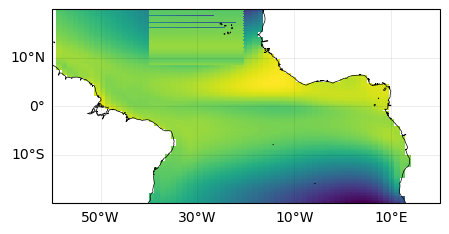

In [7]:
fig = plt.figure(figsize=(7, 5))
fig, ax = plot_setup_atlantic(fig)

ax.pcolormesh(
    data_hist["TLONG"],
    data_hist["TLAT"],
    data_hist.mean(["time", "member"]),
    transform=ccrs.PlateCarree(),
)

plt.show()

### update longitude coordinates

In [8]:
data_hist = swap_longitude_range_TLONG(data_hist)
data_rcp = swap_longitude_range_TLONG(data_rcp)

### Plot on updated coordinates

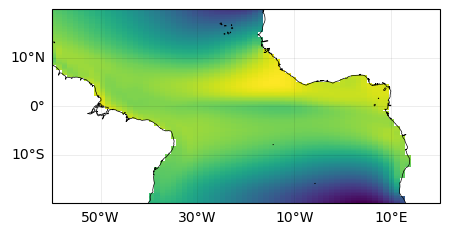

In [9]:
fig = plt.figure(figsize=(7, 5))
fig, ax = plot_setup_atlantic(fig)

ax.pcolormesh(
    data_hist["TLONG"],
    data_hist["TLAT"],
    data_hist.mean(["time", "member"]),
    transform=ccrs.PlateCarree(),
)